In [37]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, average_precision_score, auc, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [38]:
# read the given input data file for training the model
data = pd.read_csv('Fraud_Detection_Dataset.csv')
data = data.dropna(subset=['Response']) # dropping rows with null/NaN values in response

# dropping the response column and seperating the predictors from the training dataset
X_dataset = data.drop('Response', axis=1)

# storing the response data sepeartely from the training dataset
y_dataset = data['Response']

# checking for null values
X_dataset.isna().sum()

X1      0
X2      0
X3      0
X4      0
X5      0
       ..
X196    0
X197    0
X198    0
X199    0
X200    0
Length: 200, dtype: int64

In [31]:
# Define numerical and categorical features
numerical_features = X_dataset.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_dataset.select_dtypes(include=['object']).columns

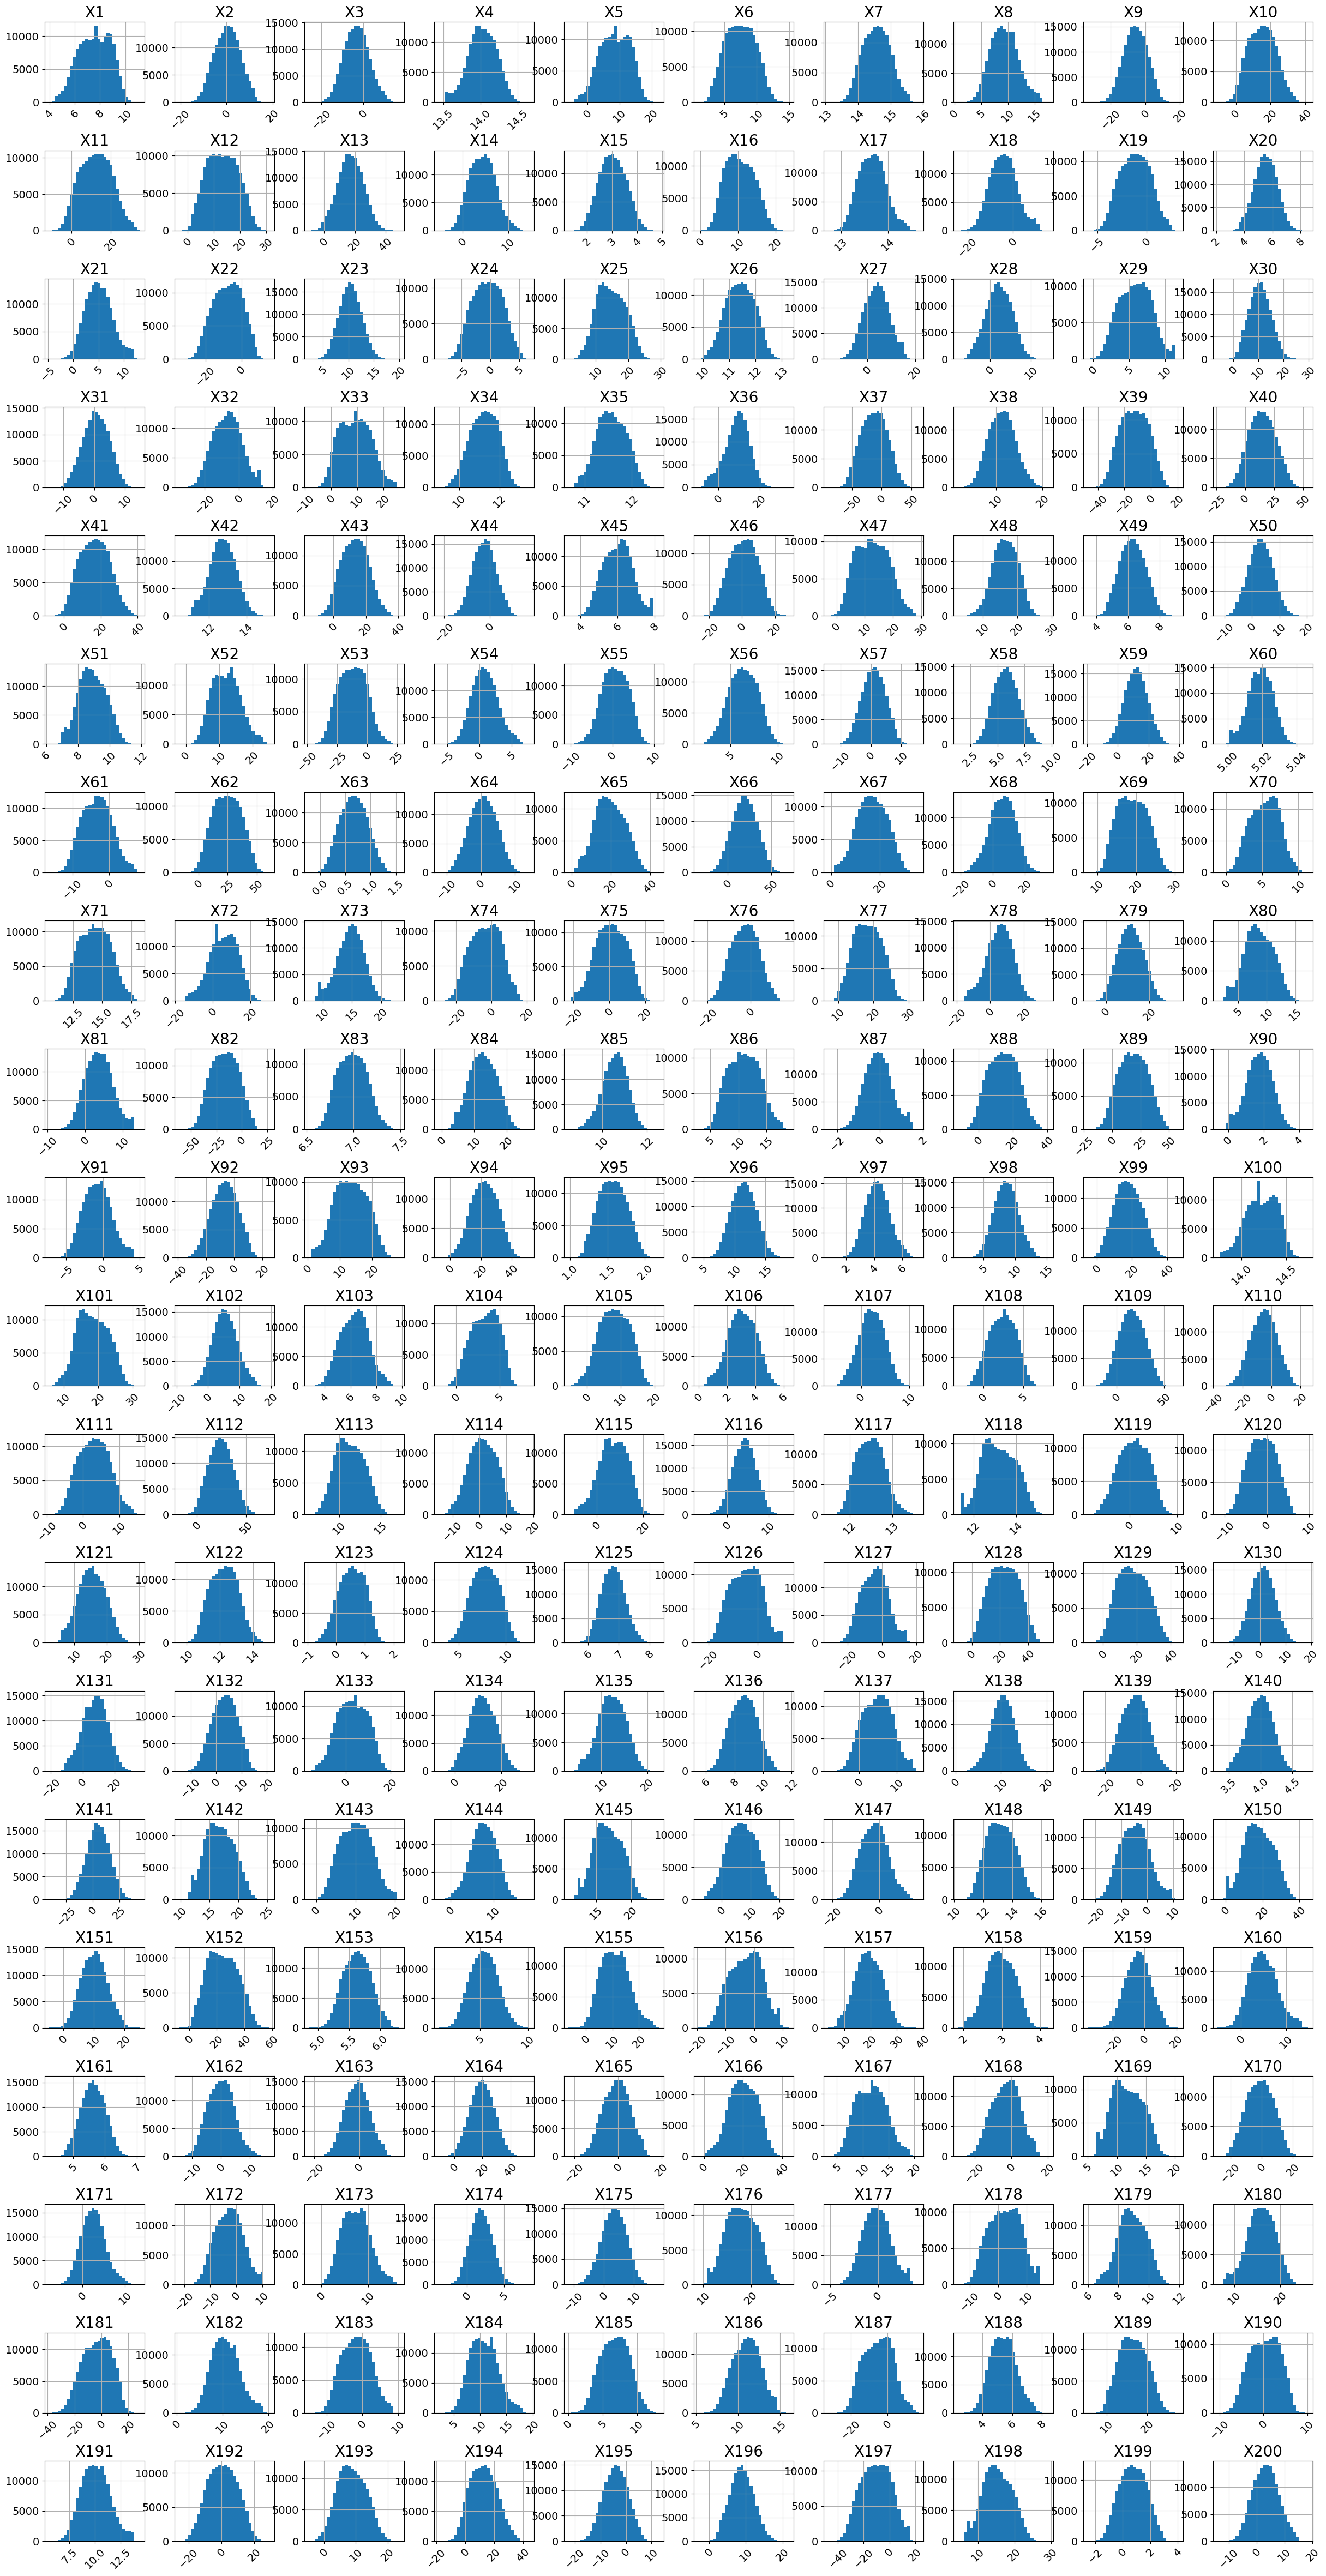

In [32]:
num_features = len(numerical_features)

cols = 10 # no of plots per row
rows = math.ceil(num_features / cols)

# Setup grid layout
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30, 3 * rows))  # adjust nrows/ncols as needed
axes = axes.flatten()

# Plot each feature histogram
for i, col in enumerate(numerical_features):
    data[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(col, fontsize=20)
    axes[i].tick_params(axis='x', labelsize=14, rotation=45)
    axes[i].tick_params(axis='y', labelsize=14)
    axes[i].locator_params(axis='x', nbins=4)
    axes[i].locator_params(axis='y', nbins=4)

plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

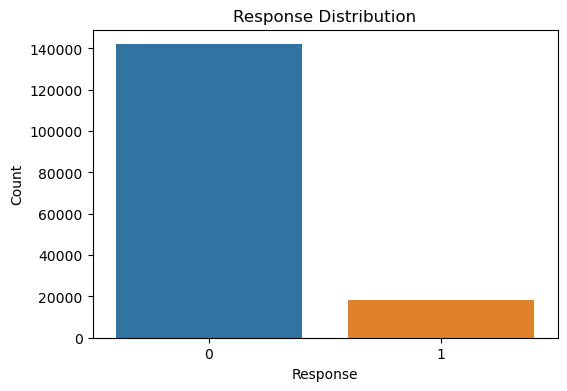

In [33]:
# Response distribution plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Response', data=y_dataset.to_frame())
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Response Distribution')
plt.show()

In [39]:
# imputating the data to handle null values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_dataset)
y_imputed = y_dataset.values

# preprocessing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# selection of features
selector = SelectKBest(score_func=f_classif, k=100)
X_selected = selector.fit_transform(X_scaled, y_imputed)

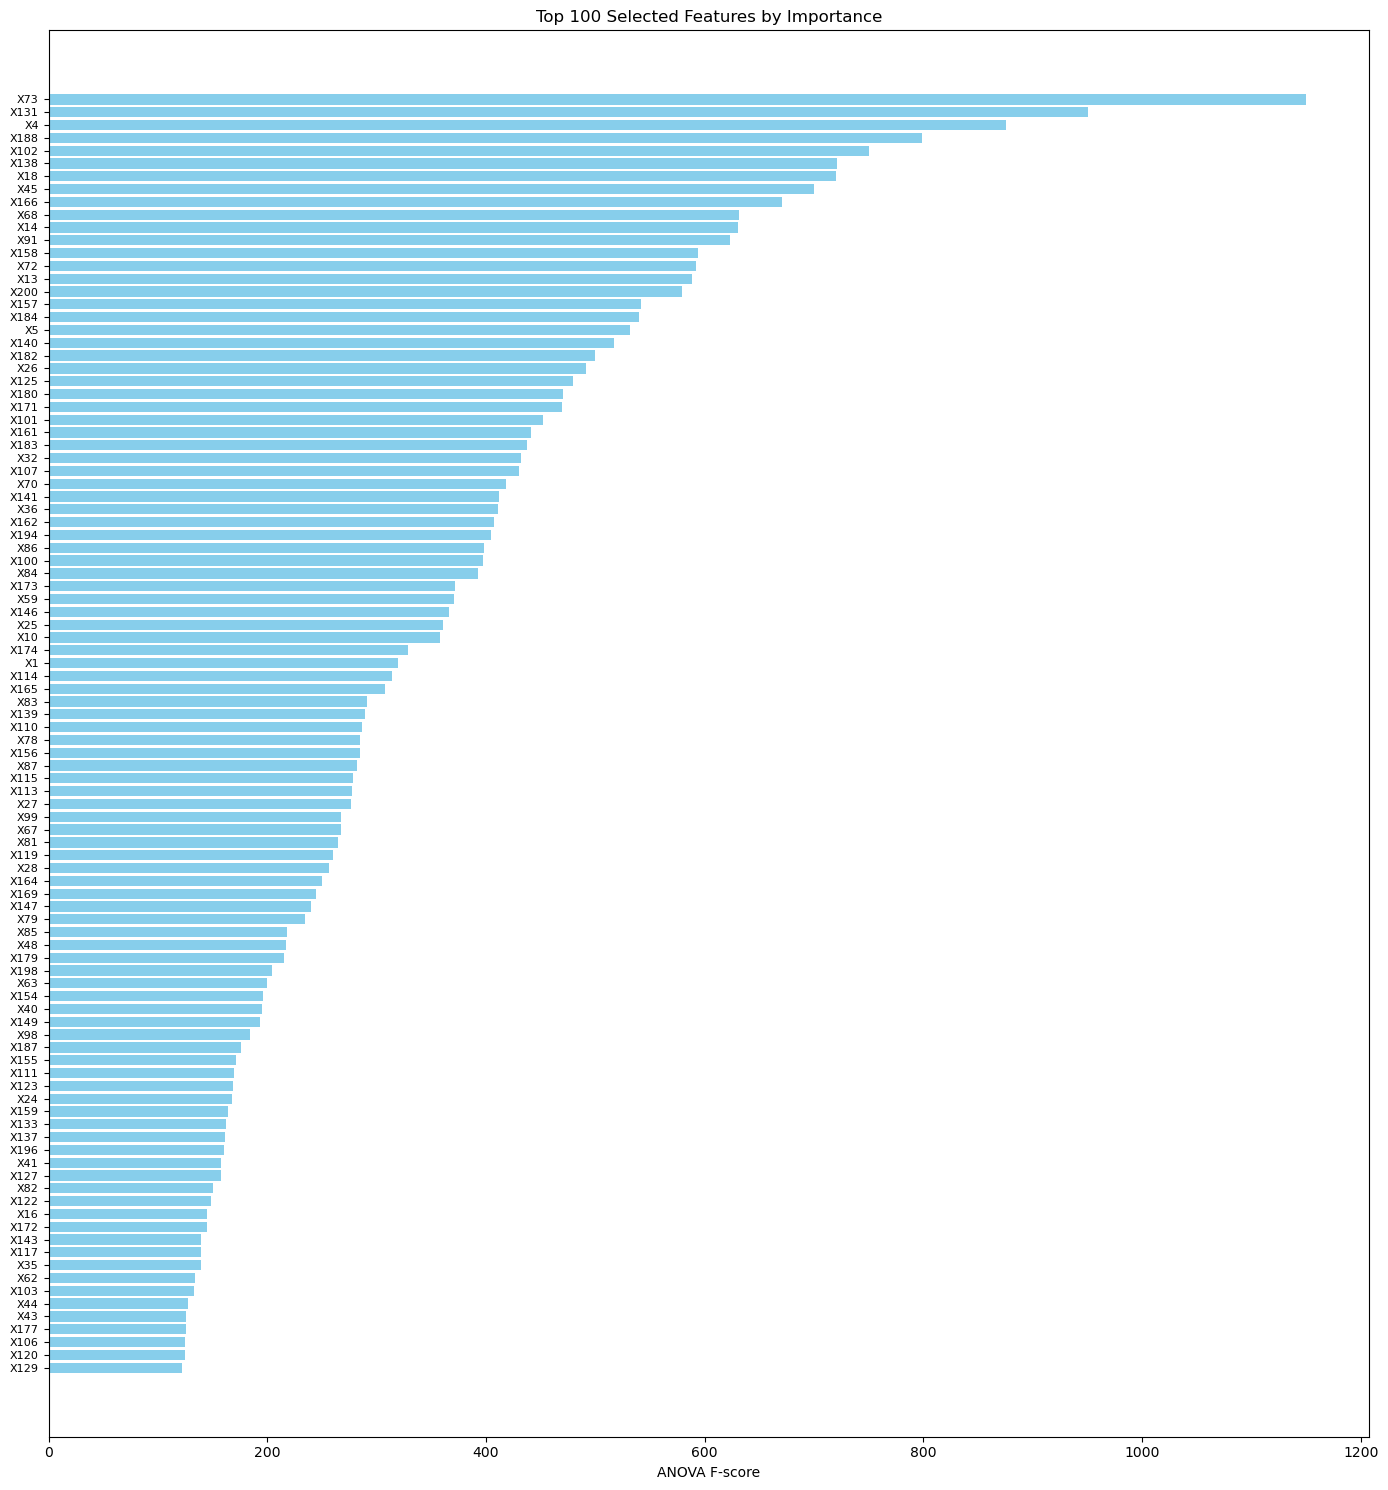

In [35]:
# Get mask of selected features
mask = selector.get_support()

# Extract selected feature names and scores
selected_features = X_dataset.columns[mask]
selected_scores = selector.scores_[mask]

# Sort by score (optional, for better visuals)
sorted_indices = np.argsort(selected_scores)[::-1]
sorted_features = selected_features[sorted_indices]
sorted_scores = selected_scores[sorted_indices]

# Plot
plt.figure(figsize=(14, 15))
plt.barh(sorted_features, sorted_scores, color='skyblue')
plt.xlabel("ANOVA F-score")
plt.title("Top 100 Selected Features by Importance")
plt.gca().invert_yaxis()  # Highest score at the top
plt.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

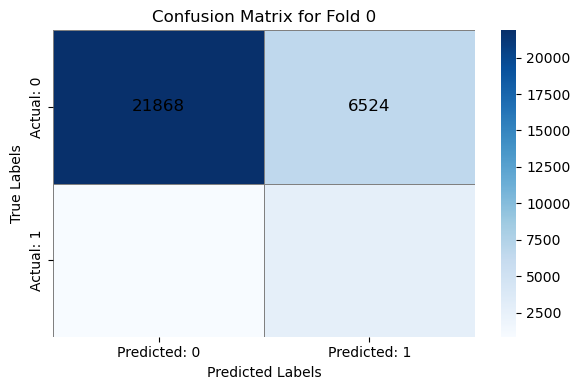

Fold 0 - Confusion Matrix Raw:
[[21868  6524]
 [  851  2757]]
Fold 0 - y_test label counts: [28392  3608]
Fold 0 - y_pred label counts: [22719  9281]


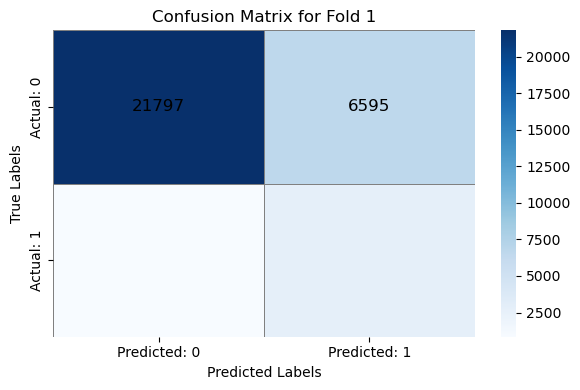

Fold 1 - Confusion Matrix Raw:
[[21797  6595]
 [  847  2761]]
Fold 1 - y_test label counts: [28392  3608]
Fold 1 - y_pred label counts: [22644  9356]


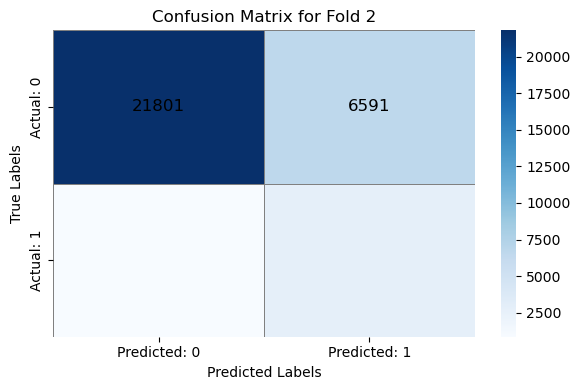

Fold 2 - Confusion Matrix Raw:
[[21801  6591]
 [  854  2754]]
Fold 2 - y_test label counts: [28392  3608]
Fold 2 - y_pred label counts: [22655  9345]


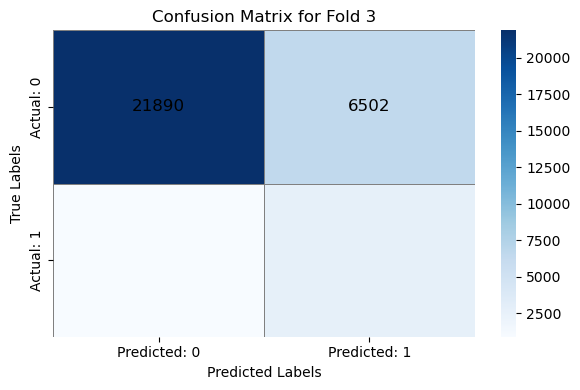

Fold 3 - Confusion Matrix Raw:
[[21890  6502]
 [  878  2730]]
Fold 3 - y_test label counts: [28392  3608]
Fold 3 - y_pred label counts: [22768  9232]


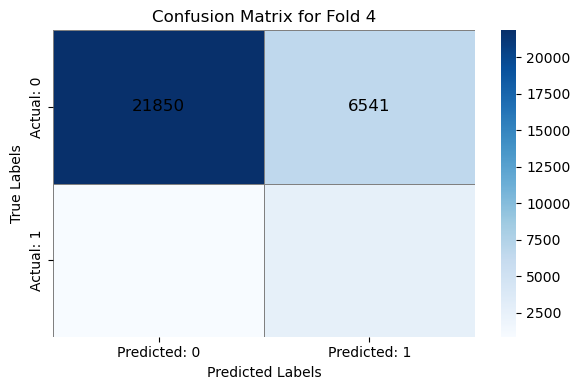

Fold 4 - Confusion Matrix Raw:
[[21850  6541]
 [  872  2736]]
Fold 4 - y_test label counts: [28391  3608]
Fold 4 - y_pred label counts: [22722  9277]


In [46]:
# model-selection and training using k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
precisions,recalls = [], []
average_precisions = []
fprS, tprS, roc_aucS = [], [], []
reports = []

for i, (train_index, test_index) in enumerate(kf.split(X_selected, y_imputed)):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y_imputed[train_index], y_imputed[test_index]

    # using Logistic Regression to fit the model
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    # predicting the response
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # predicted probability

    # evaluating accuracy for each fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # evaluating precision, recall curve for each fold
    precision, recall, _ = precision_recall_curve(y_test,y_pred)
    average_precision = average_precision_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    average_precisions.append(average_precision)

    # evaluating ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    fprS.append(fpr)
    tprS.append(tpr)

    # evaluating ROC AUC score for each fold
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_aucS.append(roc_auc)

    # evaluating classification report for each fold
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

    # confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Plot for confusion matrix (regular - '0', fradulent - '1')
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            linewidths=0.5,
            linecolor='gray',
            xticklabels=['Predicted: 0', 'Predicted: 1'],
            yticklabels=['Actual: 0', 'Actual: 1'],
            annot_kws={"size": 12, "color": "black"})
    plt.title(f'Confusion Matrix for Fold {i}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

    print(f"Fold {i} - Confusion Matrix Raw:\n{conf_matrix}")
    print(f"Fold {i} - y_test label counts: {np.bincount(y_test)}")
    print(f"Fold {i} - y_pred label counts: {np.bincount(y_pred)}")

In [ ]:
# calculating average accuracy across folds
avg_accuracy = np.mean(accuracies)
print("Average Accuracy:", avg_accuracy)

# bar plot of average accuracy across folds
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(range(len(accuracies)), accuracies, color='skyblue')
ax.set_title('Accuracy Across Folds')
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(len(accuracies)))
ax.set_xticklabels([f'Fold {i+1}' for i in range(len(accuracies))])
ax.axhline(y=avg_accuracy, color='r', linestyle='--', label=f'Average Accuracy: {avg_accuracy:.4f}')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# evaluating average recall
avg_recall = np.mean(recalls, axis=0)
print("Average Recall:", avg_recall)

# evaluating average precision
avg_precision = np.mean(precisions,axis=0)
print("Average Precision:", avg_precision)

# evaluating mean of average precision score
mean_average_precision = np.mean(average_precisions)
print("Average Precision Score:", mean_average_precision)

# Compute the area under the precision-recall curve
pr_auc = auc(avg_recall, avg_precision)

# Plot each fold's precision-recall curve
for precision, recall in zip(precisions, recalls):
    plt.plot(recall, precision, color='grey', alpha=0.3)

# Plot precision-recall curve with avg_precision and avg_recall
plt.figure()
plt.plot(avg_recall, avg_precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)'% pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# evaluating average fpr
avg_fpr = np.mean(fprS, axis=0)
print("Average fpr:", avg_fpr)

# evaluating average tpr
avg_tpr = np.mean(tprS,axis=0)
print("Average tpr:", avg_tpr)

# evaluating avgerage roc_auc score
avg_roc_auc = np.mean(roc_auc)
print("ROC AUC Score:", avg_roc_auc)

# plotting fpr,tpr for each fold
for fpr, tpr in zip(fprS, tprS):
    plt.plot(fpr, tpr, color='grey', alpha=0.3)

# Plot for ROC curve
plt.figure(figsize=(6, 4))
plt.plot(avg_fpr, avg_tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {avg_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Generating classification report for each fold
for i in range(len(reports)):
  report_df = pd.DataFrame(reports[i]).transpose()

  # Plot for classification report
  plt.figure(figsize=(6, 4))
  sns.heatmap(report_df.iloc[:, :].astype(float), annot=True, cmap='Blues', fmt='.2f')
  plt.title(f'Classification Report for Fold {i}')
  plt.show()

In [ ]:
# extracting F1 score for each class
for i in range(len(reports)):
  classes = list(reports[i].keys())[:-3]  # excluding 'accuracy', 'macro avg', and 'weighted avg'
  f1_scores = [reports[i][class_]['f1-score'] for class_ in classes]

  # Plot for F1 score of each class (0 - regular, 1 - fradulent)
  plt.figure(figsize=(6, 4))
  bars = plt.bar(classes, f1_scores, color='skyblue')
  plt.xlabel('Response')
  plt.ylabel('F1 Score')
  plt.title(f'F1 Score for Each Response for Fold {i}')
  plt.xticks(rotation=0)
  plt.ylim([0.0, 1.0])

  # Annotate each bar with its corresponding F1 score
  for bar, score in zip(bars, f1_scores):
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.4f}', ha='center')

  plt.show()

In [ ]:
# Plot for Distribution of Predicted Probablities
plt.figure(figsize=(6, 4))
plt.hist(model.predict_proba(X_selected)[:, 1], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()